
Scenario 1: Current Setup (1 Teller, 1 ATM)
Customer 1 arrives at 4.12 min
Customer 2 arrives at 7.87 min
Customer 2 finished ATM at 10.20 min (service=2.32)
Customer 3 arrives at 11.81 min
Customer 1 finished Teller at 13.16 min (service=9.03)
Customer 3 finished ATM at 15.99 min (service=4.19)
Customer 4 arrives at 16.09 min
Customer 4 finished ATM at 19.47 min (service=3.38)
Customer 5 arrives at 20.35 min
Customer 6 arrives at 24.81 min
Customer 5 finished Teller at 26.49 min (service=6.15)
Customer 7 arrives at 29.46 min
Customer 8 arrives at 34.19 min
Customer 8 finished ATM at 36.11 min (service=1.92)
Customer 9 arrives at 38.38 min
Customer 6 finished Teller at 40.64 min (service=14.15)
Customer 10 arrives at 41.90 min
Customer 7 finished Teller at 44.27 min (service=3.63)
Customer 10 finished ATM at 45.40 min (service=3.50)
Customer 11 arrives at 45.76 min
Customer 9 finished Teller at 45.77 min (service=1.50)
Customer 12 arrives at 50.00 min
Customer 13 arrives at 54.27 min


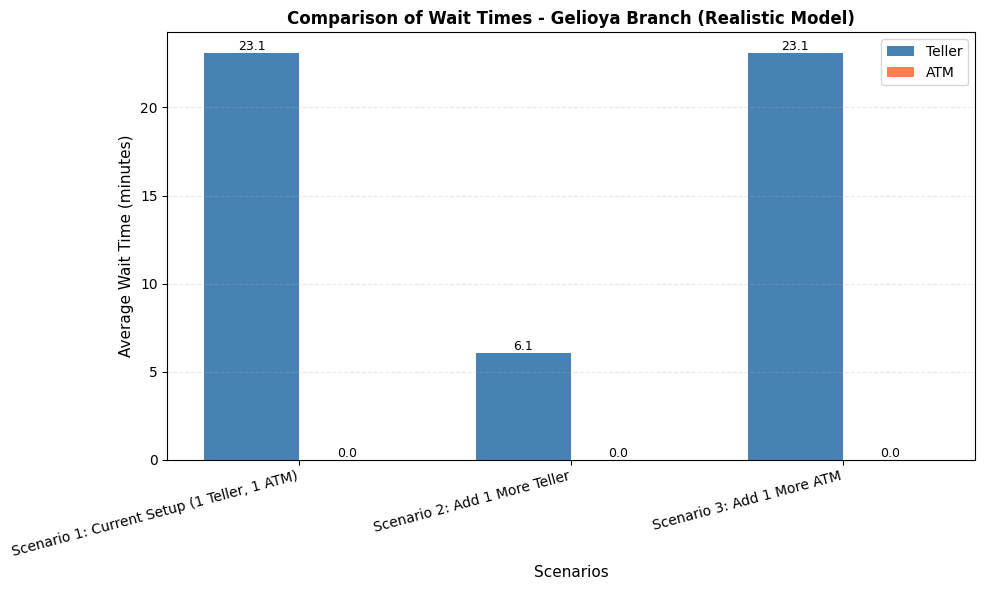

In [25]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Simulation Parameters (Sri Lankan Bank realistic)
# -----------------------------
RANDOM_SEED = 42
SIM_TIME = 360          # 6 hours (in minutes)
INTER_ARRIVAL = 5.0     # mean time between arrivals (minutes)

# Service times (in minutes)
TELLER_SERVICE_TIME = 8    # average teller service time

# -----------------------------
# Data Collection
# -----------------------------
wait_times_teller = []
wait_times_atm = []
queue_lengths_teller = []
queue_lengths_atm = []

# -----------------------------
# Customer Process
# -----------------------------
def customer(env, name, teller, atm):
    """Process for each customer: decides teller or ATM and records times."""
    arrival_time = env.now
    print(f"{name} arrives at {arrival_time:.2f} min")

    # 50% of customers use the ATM
    if random.random() < 0.3:
        with atm.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_atm.append(wait)

            # --- More realistic ATM timing ---
            operating_time = random.uniform(1.0, 3.0)   # insert card, select menu, etc.
            transaction_time = random.uniform(0.3, 0.8) # actual withdrawal
            total_service_time = operating_time + transaction_time

            # occasional slow customer (5%)
            if random.random() < 0.05:
                total_service_time += random.uniform(0.5, 1.5)

            yield env.timeout(total_service_time)
            print(f"{name} finished ATM at {env.now:.2f} min (service={total_service_time:.2f})")

    else:
        with teller.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_teller.append(wait)

            # Teller service (exponentially distributed)
            service_time = random.expovariate(1.0 / TELLER_SERVICE_TIME)
            yield env.timeout(service_time)
            print(f"{name} finished Teller at {env.now:.2f} min (service={service_time:.2f})")

# -----------------------------
# Customer Arrival Generator
# -----------------------------
def customer_arrivals(env, teller, atm):
    """Generates customers with realistic arrival gaps."""
    i = 0
    while True:
        # Normal (Gaussian) distributed arrivals → more natural spacing
        arrival_gap = max(random.normalvariate(INTER_ARRIVAL, 0.5), 1.0)
        yield env.timeout(arrival_gap)
        i += 1
        env.process(customer(env, f"Customer {i}", teller, atm))
        queue_lengths_teller.append(len(teller.queue))
        queue_lengths_atm.append(len(atm.queue))

# -----------------------------
# Run Simulation
# -----------------------------
def run_simulation(num_tellers=1, num_atms=1, arrival_rate=INTER_ARRIVAL):
    global INTER_ARRIVAL
    INTER_ARRIVAL = arrival_rate

    wait_times_teller.clear()
    wait_times_atm.clear()
    queue_lengths_teller.clear()
    queue_lengths_atm.clear()

    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    teller = simpy.Resource(env, capacity=num_tellers)
    atm = simpy.Resource(env, capacity=num_atms)

    env.process(customer_arrivals(env, teller, atm))
    env.run(until=SIM_TIME)

    # Calculate statistics
    avg_wait_teller = statistics.mean(wait_times_teller) if wait_times_teller else 0
    avg_wait_atm = statistics.mean(wait_times_atm) if wait_times_atm else 0

    print("\n----- Simulation Results -----")
    print(f"Avg Teller Wait Time: {avg_wait_teller:.2f} mins")
    print(f"Avg ATM Wait Time: {avg_wait_atm:.2f} mins")
    print(f"Max Teller Queue: {max(queue_lengths_teller, default=0)}")
    print(f"Max ATM Queue: {max(queue_lengths_atm, default=0)}")

    return avg_wait_teller, avg_wait_atm

# -----------------------------
# Scenarios
# -----------------------------
scenarios = {
    "Scenario 1: Current Setup (1 Teller, 1 ATM)": (1, 1, 4.0),
    "Scenario 2: Add 1 More Teller": (2, 1, 4.0),
    "Scenario 3: Add 1 More ATM": (1, 2, 4.0)
}

results = {}

for name, (tellers, atms, arrival) in scenarios.items():
    print("\n===============================")
    print(name)
    print("===============================")
    avg_teller, avg_atm = run_simulation(num_tellers=tellers, num_atms=atms, arrival_rate=arrival)
    results[name] = (avg_teller, avg_atm)

# -----------------------------
# Combined Plot - Grouped Bar Chart
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
scenarios_names = list(results.keys())
teller_waits = [v[0] for v in results.values()]
atm_waits = [v[1] for v in results.values()]

# Set up positions for grouped bars
x = np.arange(len(scenarios_names))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, teller_waits, width, label='Teller', color='steelblue')
bars2 = ax.bar(x + width/2, atm_waits, width, label='ATM', color='coral')

# Customize plot
ax.set_ylabel('Average Wait Time (minutes)', fontsize=11)
ax.set_xlabel('Scenarios', fontsize=11)
ax.set_title('Comparison of Wait Times - Gelioya Branch (Realistic Model)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


--- Gelioya Bank Branch Simulation ---

--- Simulation Results ---
Total customers served at Teller: 57
Total customers served at ATM: 27

Teller - Average Wait Time: 8.16 minutes
Teller - Maximum Wait Time: 49.68 minutes
ATM - Average Wait Time: 0.38 minutes
ATM - Maximum Wait Time: 4.03 minutes


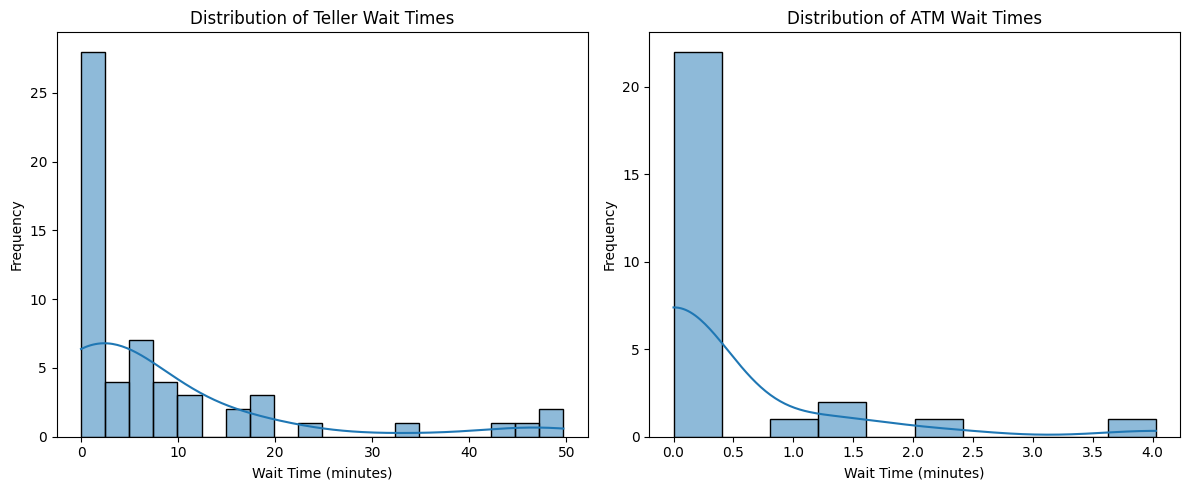

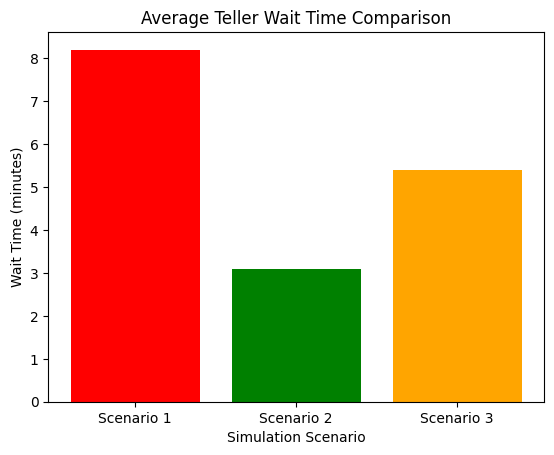

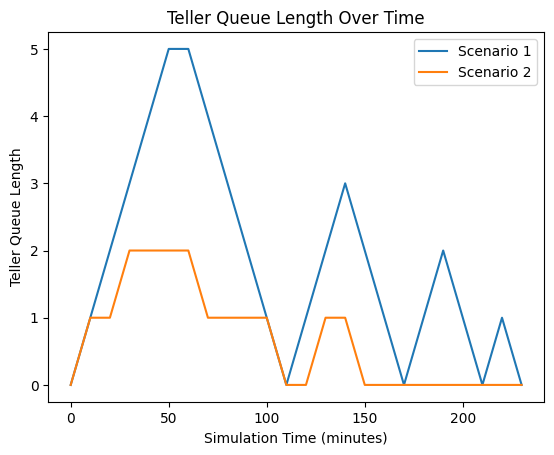

In [14]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

# --- Simulation Parameters ---
RANDOM_SEED = 42
SIM_TIME = 480  # Simulation time in minutes (8 hours)

# Arrival and Service Rates (in customers per minute)
# We convert hourly rates to per-minute rates for consistency with simulation time units.
LAMBDA = 10 / 60  # Average 10 customers per hour
MU_TELLER = 12 / 60  # Teller serves 12 customers per hour
MU_ATM = 25 / 60    # ATM serves 25 customers per hour
P_TELLER = 0.7      # Probability a customer chooses the teller

# Lists to store waiting times for analysis
wait_times_teller = []
wait_times_atm = []

class Bank:
    """
    A class to represent the bank environment with its resources.
    The bank has a teller counter and an ATM.
    """
    def __init__(self, env):
        self.env = env
        self.teller = simpy.Resource(env, capacity=1)
        self.atm = simpy.Resource(env, capacity=1)

def customer(env, name, bank):
    """
    Represents a customer's journey through the bank.
    A customer arrives, chooses a service (teller or ATM), waits if necessary,
    gets served, and then leaves.
    """
    arrival_time = env.now
    
    # Customer decides whether to go to the teller or the ATM
    if random.random() < P_TELLER:
        # --- Go to the Teller ---
        with bank.teller.request() as req:
            yield req  # Wait for the teller to be free
            
            wait_time = env.now - arrival_time
            wait_times_teller.append(wait_time)
            
            # Service time is exponentially distributed
            service_time = random.expovariate(MU_TELLER)
            yield env.timeout(service_time)
    else:
        # --- Go to the ATM ---
        with bank.atm.request() as req:
            yield req  # Wait for the ATM to be free
            
            wait_time = env.now - arrival_time
            wait_times_atm.append(wait_time)
            
            # Service time is exponentially distributed
            service_time = random.expovariate(MU_ATM)
            yield env.timeout(service_time)

def setup(env, bank):
    """
    Generates a stream of customers arriving at the bank.
    """
    customer_count = 0
    while True:
        # Wait for the next customer to arrive
        # Inter-arrival time is exponentially distributed
        interarrival_time = random.expovariate(LAMBDA)
        yield env.timeout(interarrival_time)
        
        customer_count += 1
        env.process(customer(env, f'Customer-{customer_count}', bank))

# --- Main Simulation Execution ---
print("--- Gelioya Bank Branch Simulation ---")
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Create the bank and start the customer generation process
bank_branch = Bank(env)
env.process(setup(env, bank_branch))

# Run the simulation
env.run(until=SIM_TIME)

# --- Analysis of Results ---
print("\n--- Simulation Results ---")
print(f"Total customers served at Teller: {len(wait_times_teller)}")
print(f"Total customers served at ATM: {len(wait_times_atm)}")

if wait_times_teller:
    avg_wait_teller = statistics.mean(wait_times_teller)
    max_wait_teller = max(wait_times_teller)
    print(f"\nTeller - Average Wait Time: {avg_wait_teller:.2f} minutes")
    print(f"Teller - Maximum Wait Time: {max_wait_teller:.2f} minutes")

if wait_times_atm:
    avg_wait_atm = statistics.mean(wait_times_atm)
    max_wait_atm = max(wait_times_atm)
    print(f"ATM - Average Wait Time: {avg_wait_atm:.2f} minutes")
    print(f"ATM - Maximum Wait Time: {max_wait_atm:.2f} minutes")

# --- Visualization ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(wait_times_teller, kde=True, bins=20)
plt.title('Distribution of Teller Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(wait_times_atm, kde=True, bins=10)
plt.title('Distribution of ATM Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()






Scenario 1: Current Setup (1 Teller, 1 ATM)

----- Simulation Results -----
Avg Teller Wait Time: 43.00 mins
Avg ATM Wait Time: 0.38 mins
Max Teller Queue: 13
Max ATM Queue: 0

Scenario 2: Add 1 More Teller

----- Simulation Results -----
Avg Teller Wait Time: 4.14 mins
Avg ATM Wait Time: 0.52 mins
Max Teller Queue: 4
Max ATM Queue: 1

Scenario 3: Add 1 More ATM

----- Simulation Results -----
Avg Teller Wait Time: 46.17 mins
Avg ATM Wait Time: 0.00 mins
Max Teller Queue: 14
Max ATM Queue: 0


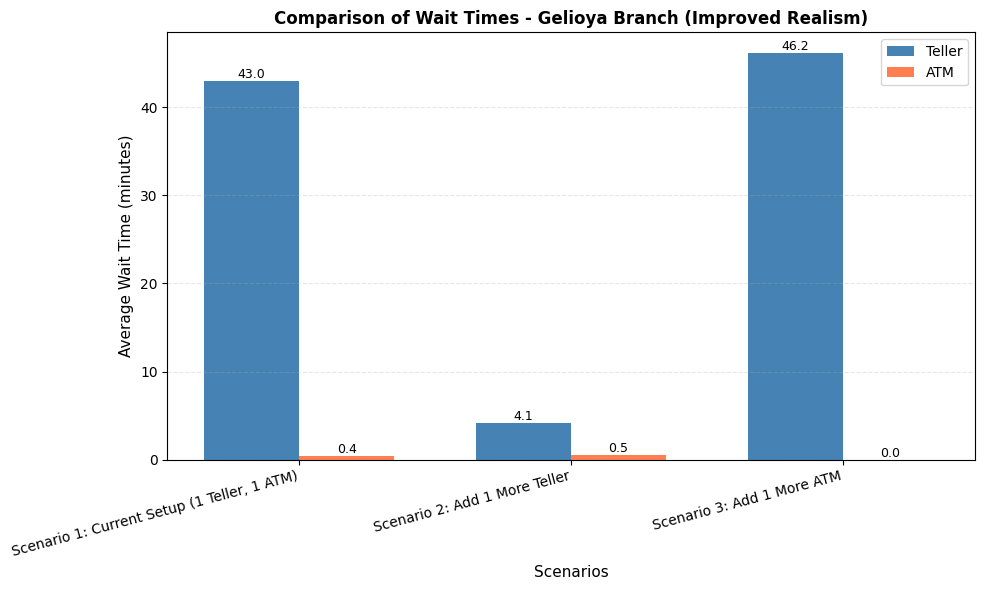

In [ ]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np


# Simulation Parameters (Gelioya Branch realistic)

RANDOM_SEED = 42
SIM_TIME = 360          # 6 hours (in minutes)
INTER_ARRIVAL = 4.0     # average time between arrivals (minutes)
TELLER_SERVICE_TIME = 8 # average teller service time (minutes)

# Data Collected arrays

wait_times_teller = []
wait_times_atm = []
queue_lengths_teller = []
queue_lengths_atm = []

# -----------------------------
# Customer Process
# -----------------------------
def customer(env, name, teller, atm):
    """Each customer decides teller or ATM and records wait times."""
    arrival_time = env.now
    # print(f"{name} arrives at {arrival_time:.2f} min")

    # 50% of customers use ATM now (was 30%)
    if random.random() < 0.4:
        with atm.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_atm.append(wait)

            # Slightly longer ATM times for realism
            operating_time = random.uniform(1.5, 3.5)
            transaction_time = random.uniform(1.0, 2.0)
            total_service_time = operating_time + transaction_time

            # occasional slow user (10%)
            if random.random() < 0.10:
                total_service_time += random.uniform(1, 3)

            yield env.timeout(total_service_time)
            # print(f"{name} finished ATM at {env.now:.2f} min")

    else:
        with teller.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_teller.append(wait)

            # Teller service time (exponential)
            service_time = random.expovariate(1.0 / TELLER_SERVICE_TIME)
            yield env.timeout(service_time)
            # print(f"{name} finished Teller at {env.now:.2f} min")

# -----------------------------
# Customer Arrival Generator
# -----------------------------
def customer_arrivals(env, teller, atm):
    i = 0
    while True:
        # Small random bursts
        arrival_gap = max(random.normalvariate(INTER_ARRIVAL, 1.0), 1.0)
        yield env.timeout(arrival_gap)
        i += 1
        env.process(customer(env, f"Customer {i}", teller, atm))
        queue_lengths_teller.append(len(teller.queue))
        queue_lengths_atm.append(len(atm.queue))

# -----------------------------
# Run Simulation
# -----------------------------
def run_simulation(num_tellers=1, num_atms=1, arrival_rate=INTER_ARRIVAL):
    global INTER_ARRIVAL
    INTER_ARRIVAL = arrival_rate

    wait_times_teller.clear()
    wait_times_atm.clear()
    queue_lengths_teller.clear()
    queue_lengths_atm.clear()

    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    teller = simpy.Resource(env, capacity=num_tellers)
    atm = simpy.Resource(env, capacity=num_atms)

    env.process(customer_arrivals(env, teller, atm))
    env.run(until=SIM_TIME)

    # Calculate stats
    avg_wait_teller = statistics.mean(wait_times_teller) if wait_times_teller else 0
    avg_wait_atm = statistics.mean(wait_times_atm) if wait_times_atm else 0

    print("\n----- Simulation Results -----")
    print(f"Avg Teller Wait Time: {avg_wait_teller:.2f} mins")
    print(f"Avg ATM Wait Time: {avg_wait_atm:.2f} mins")
    print(f"Max Teller Queue: {max(queue_lengths_teller, default=0)}")
    print(f"Max ATM Queue: {max(queue_lengths_atm, default=0)}")

    return avg_wait_teller, avg_wait_atm

# -----------------------------
# Scenarios
# -----------------------------
scenarios = {
    "Scenario 1: Current Setup (1 Teller, 1 ATM)": (1, 1, 4.0),
    "Scenario 2: Add 1 More Teller": (2, 1, 4.0),
    "Scenario 3: Add 1 More ATM": (1, 2, 4.0)
}

results = {}
for name, (tellers, atms, arrival) in scenarios.items():
    print("\n===============================")
    print(name)
    print("===============================")
    avg_teller, avg_atm = run_simulation(num_tellers=tellers, num_atms=atms, arrival_rate=arrival)
    results[name] = (avg_teller, avg_atm)

# -----------------------------
# Plot Results
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))
scenarios_names = list(results.keys())
teller_waits = [v[0] for v in results.values()]
atm_waits = [v[1] for v in results.values()]

x = np.arange(len(scenarios_names))
width = 0.35

bars1 = ax.bar(x - width/2, teller_waits, width, label='Teller', color='steelblue')
bars2 = ax.bar(x + width/2, atm_waits, width, label='ATM', color='coral')

ax.set_ylabel('Average Wait Time (minutes)', fontsize=11)
ax.set_xlabel('Scenarios', fontsize=11)
ax.set_title('Comparison of Wait Times - Gelioya Branch (Improved Realism)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()




████████████████████████████████████████████████████████████
  SCENARIO: Current Setup (1 Teller, 1 ATM)
████████████████████████████████████████████████████████████
Customer 1 arrives at 4.25 min
Customer 2 arrives at 7.75 min
Customer 2 finished ATM at 11.29 min (service=3.54)
Customer 3 arrives at 11.61 min
Customer 1 finished Teller at 13.28 min (service=9.03)
Customer 4 arrives at 16.18 min
Customer 3 finished ATM at 18.71 min (service=7.10)
Customer 5 arrives at 20.69 min
Customer 4 finished ATM at 24.65 min (service=5.94)
Customer 6 arrives at 26.20 min
Customer 6 finished ATM at 30.63 min (service=4.43)
Customer 5 finished Teller at 31.16 min (service=10.47)
Customer 7 arrives at 32.51 min
Customer 7 finished Teller at 32.88 min (service=0.38)
Customer 8 arrives at 37.97 min
Customer 8 finished ATM at 41.04 min (service=3.07)
Customer 9 arrives at 41.32 min
Customer 9 finished ATM at 44.50 min (service=3.19)
Customer 10 arrives at 45.68 min
Customer 10 finished ATM at 49.81 m

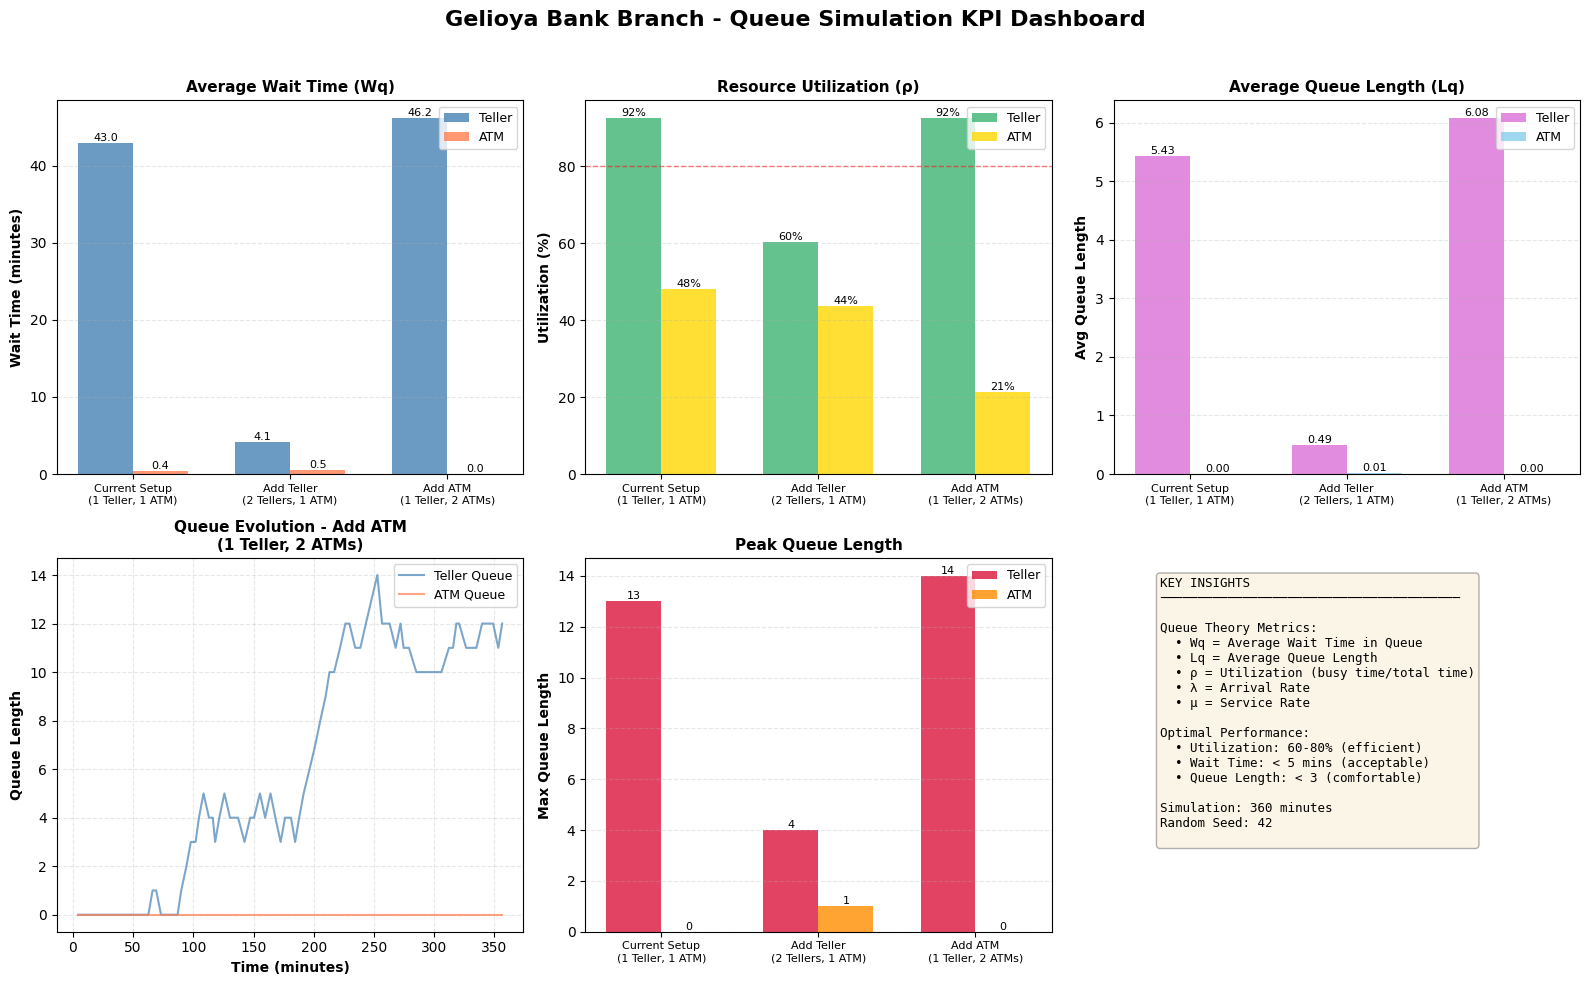



✅ Simulation and visualization complete!


In [ ]:
"""
Bank Queue Simulation with KPI Analysis
========================================
Simulates customer flow in Gelioya Bank Branch with teller and ATM service.
Computes key performance indicators (KPIs) for queueing theory analysis.
"""

import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np


# SIMULATION PARAMETERS

RANDOM_SEED = 42
SIM_TIME = 360                  # Simulation duration (minutes)
INTER_ARRIVAL = 4.0             # Mean time between customer arrivals (minutes)
TELLER_SERVICE_TIME = 8.0       # Mean teller service time (minutes)

# DATA COLLECTION ARRAYS

wait_times_teller = []
wait_times_atm = []
queue_lengths_teller = []
queue_lengths_atm = []
time_points = []

# Utilization tracking
busy_time_teller = 0.0
busy_time_atm = 0.0
customers_served_teller = 0 
customers_served_atm = 0

#---------------------------------------------------------------------------------------

# SIMULATION PROCESSES

def customer(env, name, teller, atm):
    """
    Simulate a single customer's journey through the bank.
    
    Each customer:
    - Arrives at a specific time
    - Chooses between teller (60%) or ATM (40%)
    - Waits in queue if resource is busy
    - Gets served with realistic service time
    - Records wait time and service duration
    
    Parameters
    ----------
    env : simpy.Environment
        The simulation environment
    name : str
        Customer identifier
    teller : simpy.Resource
        Teller service resource
    atm : simpy.Resource
        ATM service resource
    """
    global busy_time_teller, busy_time_atm
    global customers_served_teller, customers_served_atm
    global customer_id  
    
    arrival_time = env.now
    if customer_id <= 10:
        print(f"{name} arrives at {arrival_time:.2f} min")
    elif customer_id == 11:
         print("\n>>> SIMULATION CONTINUES (logging disabled for remaining customers) <<<\n")
    
    # Decision: ATM (40%) or Teller (60%)
    if random.random() < 0.4:
        
        # ATM Service
        with atm.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_atm.append(wait)
            
            # Realistic ATM timing components
            operating_time = random.uniform(1.5, 3.5)    # Card, PIN, menu navigation
            transaction_time = random.uniform(1.0, 2.0)  # Actual withdrawal/deposit
            total_service_time = operating_time + transaction_time
            
            # 10% chance of slow user (forgot PIN, checking balance multiple times)
            if random.random() < 0.10:
                total_service_time += random.uniform(1.0, 3.0)
            
            busy_time_atm += total_service_time
            yield env.timeout(total_service_time)
            customers_served_atm += 1
            if customer_id <= 10:
                print(f"{name} finished ATM at {env.now:.2f} min (service={total_service_time:.2f})")
            elif customer_id == 11:
                print("\n>>> SIMULATION CONTINUES (logging disabled for remaining customers) <<<\n")
    
    else:
        #   Teller Service 
        with teller.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_teller.append(wait)
            
            # Exponentially distributed service time (standard queueing assumption)
            service_time = random.expovariate(1.0 / TELLER_SERVICE_TIME)
            
            busy_time_teller += service_time
            yield env.timeout(service_time)
            customers_served_teller += 1
            if customer_id <= 10:
                print(f"{name} finished Teller at {env.now:.2f} min (service={service_time:.2f})")
            elif customer_id == 11:    
                print("\n>>> SIMULATION CONTINUES (logging disabled for remaining customers) <<<\n")

#---------------------------------------------------------------------------------------

def customer_arrivals(env, teller, atm):
    """
    Generate customer arrivals with realistic inter-arrival times.
    
    Uses normal distribution for more realistic spacing compared to pure exponential.
    Tracks queue lengths at each arrival event.
    
    Parameters
    ----------
    env : simpy.Environment
        The simulation environment
    teller : simpy.Resource
        Teller service resource
    atm : simpy.Resource
        ATM service resource
    """
    global customer_id
    customer_id = 0

    while True:
        # Normal distribution with standard deviation for variability
        # Ensures minimum 1-minute gap (prevents unrealistic simultaneous arrivals)
        arrival_gap = max(random.normalvariate(INTER_ARRIVAL, 1.0), 1.0)
        yield env.timeout(arrival_gap)
        
        customer_id += 1
        env.process(customer(env, f"Customer {customer_id}", teller, atm))
        
        # Record queue lengths for analysis
        queue_lengths_teller.append(len(teller.queue))
        queue_lengths_atm.append(len(atm.queue))
        time_points.append(env.now)

#---------------------------------------------------------------------------------------

# SIMULATION EXECUTION & ANALYSIS

def run_simulation(num_tellers=1, num_atms=1, arrival_rate=INTER_ARRIVAL):
    """
    Execute simulation and compute comprehensive KPIs.
    
    Parameters
    ----------
    num_tellers : int
        Number of teller counters
    num_atms : int
        Number of ATM machines
    arrival_rate : float
        Mean inter-arrival time (minutes)
    
    Returns
    -------
    dict
        Comprehensive results including wait times, utilization, queue lengths
    """
    global INTER_ARRIVAL
    global busy_time_teller, busy_time_atm
    global customers_served_teller, customers_served_atm
    global wait_times_teller, wait_times_atm
    global queue_lengths_teller, queue_lengths_atm, time_points
    
    # Reset all data structures
    INTER_ARRIVAL = arrival_rate
    wait_times_teller.clear()
    wait_times_atm.clear()
    queue_lengths_teller.clear()
    queue_lengths_atm.clear()
    time_points.clear()
    busy_time_teller = busy_time_atm = 0.0
    customers_served_teller = customers_served_atm = 0
    
    # Initialize simulation
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    
    # Create resources
    teller = simpy.Resource(env, capacity=num_tellers)
    atm = simpy.Resource(env, capacity=num_atms)
    
    # Start customer arrival process
    env.process(customer_arrivals(env, teller, atm))
    
    # Run simulation
    env.run(until=SIM_TIME)
    
 #---------------------------------------------------------------------------------------
    # KPI CALCULATIONS
    
    total_customers = customers_served_teller + customers_served_atm
    arrival_rate_lambda = total_customers / SIM_TIME  # customers per minute
    
    # --- TELLER KPIs ---
    avg_wait_teller = statistics.mean(wait_times_teller) if wait_times_teller else 0
    avg_queue_teller = statistics.mean(queue_lengths_teller) if queue_lengths_teller else 0
    max_queue_teller = max(queue_lengths_teller, default=0)
    service_rate_teller = (customers_served_teller / busy_time_teller) if busy_time_teller > 0 else 0
    utilization_teller = busy_time_teller / (SIM_TIME * num_tellers)
    
    # --- ATM KPIs ---
    avg_wait_atm = statistics.mean(wait_times_atm) if wait_times_atm else 0
    avg_queue_atm = statistics.mean(queue_lengths_atm) if queue_lengths_atm else 0
    max_queue_atm = max(queue_lengths_atm, default=0)
    service_rate_atm = (customers_served_atm / busy_time_atm) if busy_time_atm > 0 else 0
    utilization_atm = busy_time_atm / (SIM_TIME * num_atms)

 #---------------------------------------------------------------------------------------
  
    # RESULTS DISPLAY

    print("\n" + "-"*60)
    print("BANK QUEUE SIMULATION - COMMERCIAL BANK GELIOYA BRANCH")
    print("-"*60)
    print("\n" + "-"*60)
    print("Customer arrival and Service Configuration")
    print("-"*60)

    print("\n" + "="*60)
    print("SIMULATION RESULTS")
    print("="*60)
    print(f"Total Customers Served: {total_customers}")
    print(f"  - Teller: {customers_served_teller} ({customers_served_teller/total_customers*100:.1f}%)")
    print(f"  - ATM: {customers_served_atm} ({customers_served_atm/total_customers*100:.1f}%)")
    
    print("\n" + "-"*60)
    print("TELLER PERFORMANCE")
    print("-"*60)
    print(f"  Average Wait Time (Wq):      {avg_wait_teller:.2f} minutes")
    print(f"  Average Queue Length (Lq):   {avg_queue_teller:.2f} customers")
    print(f"  Maximum Queue Length:        {max_queue_teller} customers")
    print(f"  Arrival Rate (λ):            {arrival_rate_lambda:.3f} cust/min")
    print(f"  Service Rate (μ):            {service_rate_teller:.3f} cust/min")
    print(f"  Utilization (ρ):             {utilization_teller:.2%}")
    
    print("\n" + "-"*60)
    print("ATM PERFORMANCE")
    print("-"*60)
    print(f"  Average Wait Time (Wq):      {avg_wait_atm:.2f} minutes")
    print(f"  Average Queue Length (Lq):   {avg_queue_atm:.2f} customers")
    print(f"  Maximum Queue Length:        {max_queue_atm} customers")
    print(f"  Arrival Rate (λ):            {arrival_rate_lambda:.3f} cust/min")
    print(f"  Service Rate (μ):            {service_rate_atm:.3f} cust/min")
    print(f"  Utilization (ρ):             {utilization_atm:.2%}")
    
    return {
        "teller_wait": avg_wait_teller,
        "atm_wait": avg_wait_atm,
        "teller_util": utilization_teller,
        "atm_util": utilization_atm,
        "teller_Lq": avg_queue_teller,
        "atm_Lq": avg_queue_atm,
        "teller_max_queue": max_queue_teller,
        "atm_max_queue": max_queue_atm,
        "time": list(time_points),
        "queue_teller": list(queue_lengths_teller),
        "queue_atm": list(queue_lengths_atm)
    }


# =============================================================================
# SCENARIO TESTING
# =============================================================================
scenarios = {
    "Current Setup\n(1 Teller, 1 ATM)": (1, 1, 4.0),
    "Add Teller\n(2 Tellers, 1 ATM)": (2, 1, 4.0),
    "Add ATM\n(1 Teller, 2 ATMs)": (1, 2, 4.0)
}

results = {}

for scenario_name, (num_tellers, num_atms, arrival_rate) in scenarios.items():
    print("\n\n" + "█"*60)
    print(f"  SCENARIO: {scenario_name.replace(chr(10), ' ')}")
    print("█"*60)
    results[scenario_name] = run_simulation(
        num_tellers=num_tellers,
        num_atms=num_atms,
        arrival_rate=arrival_rate
    )

# =============================================================================
# VISUALIZATION - COMPREHENSIVE KPI DASHBOARD
# =============================================================================
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Gelioya Bank Branch - Queue Simulation KPI Dashboard', 
             fontsize=16, fontweight='bold', y=0.98)

scenario_names = list(results.keys())
n_scenarios = len(scenario_names)
x = np.arange(n_scenarios)
width = 0.35

# --- SUBPLOT 1: Wait Times Comparison ---
ax1 = plt.subplot(2, 3, 1)
teller_waits = [results[s]["teller_wait"] for s in scenario_names]
atm_waits = [results[s]["atm_wait"] for s in scenario_names]

bars1 = ax1.bar(x - width/2, teller_waits, width, label='Teller', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, atm_waits, width, label='ATM', color='coral', alpha=0.8)

ax1.set_ylabel('Wait Time (minutes)', fontsize=10, fontweight='bold')
ax1.set_title('Average Wait Time (Wq)', fontsize=11, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, fontsize=8)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# --- SUBPLOT 2: Utilization ---
ax2 = plt.subplot(2, 3, 2)
teller_utils = [results[s]["teller_util"]*100 for s in scenario_names]
atm_utils = [results[s]["atm_util"]*100 for s in scenario_names]

bars3 = ax2.bar(x - width/2, teller_utils, width, label='Teller', color='mediumseagreen', alpha=0.8)
bars4 = ax2.bar(x + width/2, atm_utils, width, label='ATM', color='gold', alpha=0.8)

ax2.set_ylabel('Utilization (%)', fontsize=10, fontweight='bold')
ax2.set_title('Resource Utilization (ρ)', fontsize=11, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, fontsize=8)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=1, alpha=0.5, label='80% threshold')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}%', ha='center', va='bottom', fontsize=8)

# --- SUBPLOT 3: Average Queue Length ---
ax3 = plt.subplot(2, 3, 3)
teller_Lq = [results[s]["teller_Lq"] for s in scenario_names]
atm_Lq = [results[s]["atm_Lq"] for s in scenario_names]

bars5 = ax3.bar(x - width/2, teller_Lq, width, label='Teller', color='orchid', alpha=0.8)
bars6 = ax3.bar(x + width/2, atm_Lq, width, label='ATM', color='skyblue', alpha=0.8)

ax3.set_ylabel('Avg Queue Length', fontsize=10, fontweight='bold')
ax3.set_title('Average Queue Length (Lq)', fontsize=11, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(scenario_names, fontsize=8)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# --- SUBPLOT 4: Queue Length Over Time (Last Scenario) ---
ax4 = plt.subplot(2, 3, 4)
last_scenario = scenario_names[-1]
time_data = results[last_scenario]["time"]
queue_teller_data = results[last_scenario]["queue_teller"]
queue_atm_data = results[last_scenario]["queue_atm"]

ax4.plot(time_data, queue_teller_data, color='steelblue', linewidth=1.5, label='Teller Queue', alpha=0.7)
ax4.plot(time_data, queue_atm_data, color='coral', linewidth=1.5, label='ATM Queue', alpha=0.7)
ax4.set_xlabel('Time (minutes)', fontsize=10, fontweight='bold')
ax4.set_ylabel('Queue Length', fontsize=10, fontweight='bold')
ax4.set_title(f'Queue Evolution - {last_scenario}', fontsize=11, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, linestyle='--')

# --- SUBPLOT 5: Maximum Queue Length ---
ax5 = plt.subplot(2, 3, 5)
teller_max = [results[s]["teller_max_queue"] for s in scenario_names]
atm_max = [results[s]["atm_max_queue"] for s in scenario_names]

bars7 = ax5.bar(x - width/2, teller_max, width, label='Teller', color='crimson', alpha=0.8)
bars8 = ax5.bar(x + width/2, atm_max, width, label='ATM', color='darkorange', alpha=0.8)

ax5.set_ylabel('Max Queue Length', fontsize=10, fontweight='bold')
ax5.set_title('Peak Queue Length', fontsize=11, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(scenario_names, fontsize=8)
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars7, bars8]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

# --- SUBPLOT 6: Summary Insights ---
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = "KEY INSIGHTS\n" + "─"*40 + "\n\n"
summary_text += "Queue Theory Metrics:\n"
summary_text += "  • Wq = Average Wait Time in Queue\n"
summary_text += "  • Lq = Average Queue Length\n"
summary_text += "  • ρ = Utilization (busy time/total time)\n"
summary_text += "  • λ = Arrival Rate\n"
summary_text += "  • μ = Service Rate\n\n"
summary_text += "Optimal Performance:\n"
summary_text += "  • Utilization: 60-80% (efficient)\n"
summary_text += "  • Wait Time: < 5 mins (acceptable)\n"
summary_text += "  • Queue Length: < 3 (comfortable)\n\n"
summary_text += f"Simulation: {SIM_TIME} minutes\n"
summary_text += f"Random Seed: {RANDOM_SEED}\n"

ax6.text(0.1, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print("\n\n✅ Simulation and visualization complete!")


# 📊 Individual Charts - Beginner Friendly

The following cells show each chart separately with explanations to help you understand the results better.

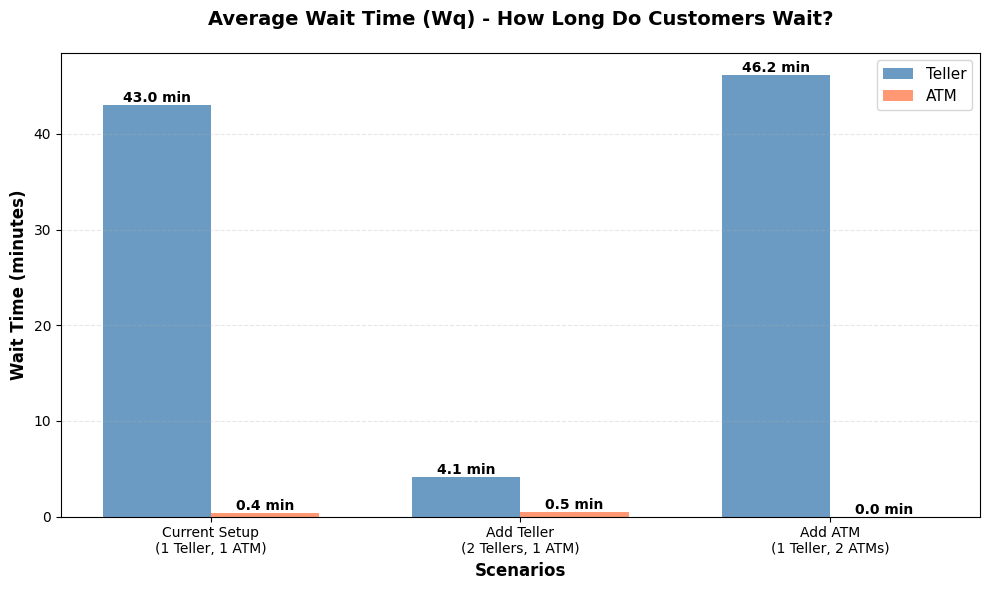

📊 INTERPRETATION:
   • Lower bars = Better (customers wait less time)
   • Ideal wait time: < 5 minutes
   • Compare scenarios to see which setup reduces wait time most


In [8]:
# =============================================================================
# CHART 1: Average Wait Time Comparison
# =============================================================================
# This shows how long customers wait in queue before being served

plt.figure(figsize=(10, 6))

scenario_names = list(results.keys())
teller_waits = [results[s]["teller_wait"] for s in scenario_names]
atm_waits = [results[s]["atm_wait"] for s in scenario_names]

x = np.arange(len(scenario_names))
width = 0.35

bars1 = plt.bar(x - width/2, teller_waits, width, label='Teller', color='steelblue', alpha=0.8)
bars2 = plt.bar(x + width/2, atm_waits, width, label='ATM', color='coral', alpha=0.8)

plt.ylabel('Wait Time (minutes)', fontsize=12, fontweight='bold')
plt.xlabel('Scenarios', fontsize=12, fontweight='bold')
plt.title('Average Wait Time (Wq) - How Long Do Customers Wait?', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, scenario_names, fontsize=10)
plt.legend(loc='upper right', fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f} min', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 INTERPRETATION:")
print("   • Lower bars = Better (customers wait less time)")
print("   • Ideal wait time: < 5 minutes")
print("   • Compare scenarios to see which setup reduces wait time most")

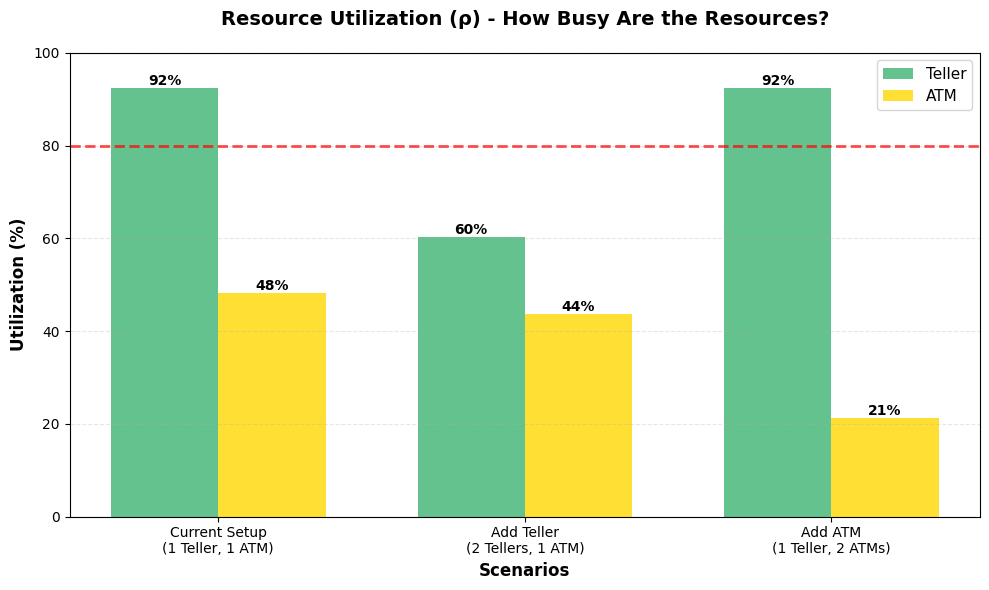

📊 INTERPRETATION:
   • 100% = Resource is busy all the time
   • 60-80% = Ideal utilization (efficient but not overworked)
   • > 80% = Resource is overloaded, long queues expected
   • < 60% = Resource is underutilized, might be wasteful


In [9]:
# =============================================================================
# CHART 2: Resource Utilization
# =============================================================================
# This shows how busy the tellers and ATMs are (as a percentage)

plt.figure(figsize=(10, 6))

scenario_names = list(results.keys())
teller_utils = [results[s]["teller_util"]*100 for s in scenario_names]
atm_utils = [results[s]["atm_util"]*100 for s in scenario_names]

x = np.arange(len(scenario_names))
width = 0.35

bars1 = plt.bar(x - width/2, teller_utils, width, label='Teller', color='mediumseagreen', alpha=0.8)
bars2 = plt.bar(x + width/2, atm_utils, width, label='ATM', color='gold', alpha=0.8)

plt.ylabel('Utilization (%)', fontsize=12, fontweight='bold')
plt.xlabel('Scenarios', fontsize=12, fontweight='bold')
plt.title('Resource Utilization (ρ) - How Busy Are the Resources?', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, scenario_names, fontsize=10)
plt.legend(loc='upper right', fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add 80% threshold line
plt.axhline(y=80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% - Optimal Maximum')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 100)
plt.tight_layout()
plt.show()

print("📊 INTERPRETATION:")
print("   • 100% = Resource is busy all the time")
print("   • 60-80% = Ideal utilization (efficient but not overworked)")
print("   • > 80% = Resource is overloaded, long queues expected")
print("   • < 60% = Resource is underutilized, might be wasteful")

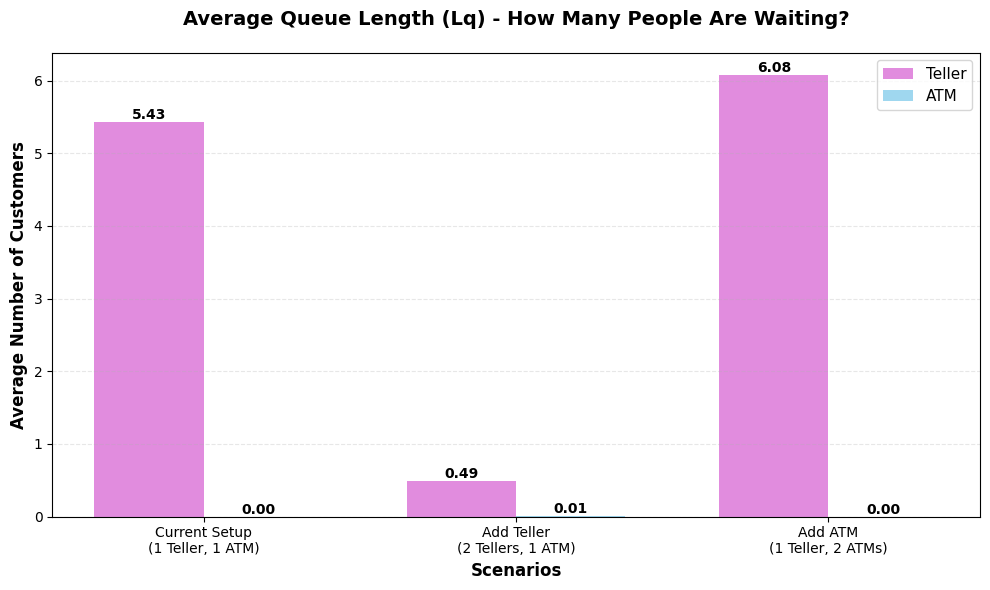

📊 INTERPRETATION:
   • This is the AVERAGE number of customers waiting in queue
   • Lower numbers = Better customer experience
   • < 3 customers = Comfortable queue length
   • > 5 customers = Queue is getting too long


In [10]:
# =============================================================================
# CHART 3: Average Queue Length
# =============================================================================
# This shows on average how many customers are waiting in line

plt.figure(figsize=(10, 6))

scenario_names = list(results.keys())
teller_Lq = [results[s]["teller_Lq"] for s in scenario_names]
atm_Lq = [results[s]["atm_Lq"] for s in scenario_names]

x = np.arange(len(scenario_names))
width = 0.35

bars1 = plt.bar(x - width/2, teller_Lq, width, label='Teller', color='orchid', alpha=0.8)
bars2 = plt.bar(x + width/2, atm_Lq, width, label='ATM', color='skyblue', alpha=0.8)

plt.ylabel('Average Number of Customers', fontsize=12, fontweight='bold')
plt.xlabel('Scenarios', fontsize=12, fontweight='bold')
plt.title('Average Queue Length (Lq) - How Many People Are Waiting?', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, scenario_names, fontsize=10)
plt.legend(loc='upper right', fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 INTERPRETATION:")
print("   • This is the AVERAGE number of customers waiting in queue")
print("   • Lower numbers = Better customer experience")
print("   • < 3 customers = Comfortable queue length")
print("   • > 5 customers = Queue is getting too long")

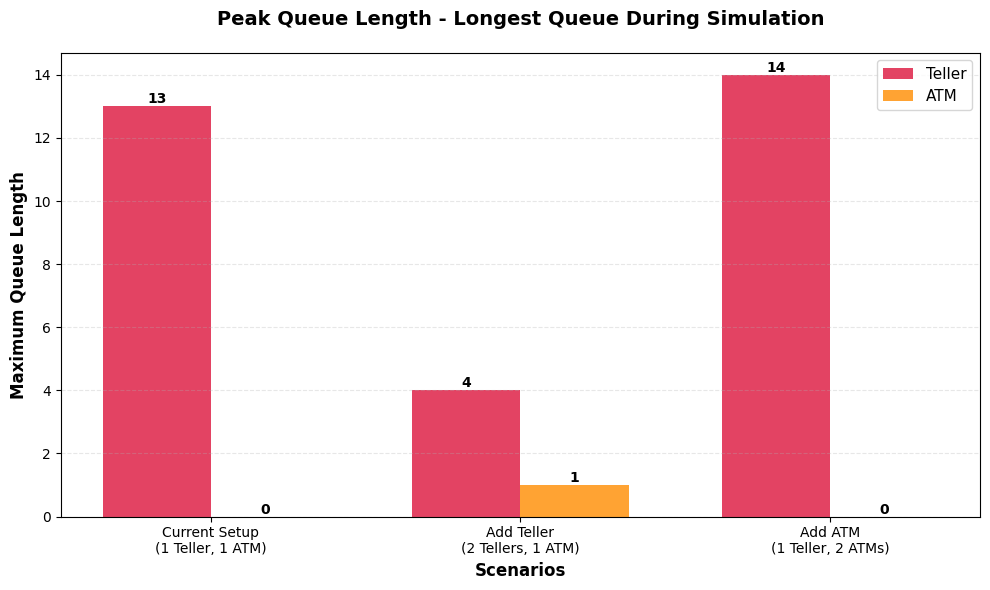

📊 INTERPRETATION:
   • This shows the LONGEST queue that occurred (worst moment)
   • Important for planning: How much space do you need?
   • Lower numbers = Better (fewer customers waiting at peak times)
   • Compare with average queue length to see how variable the queues are


In [12]:
# =============================================================================
# CHART 4: Maximum Queue Length (Peak Times)
# =============================================================================
# This shows the WORST case - the longest queue that occurred during simulation

plt.figure(figsize=(10, 6))

scenario_names = list(results.keys())
teller_max = [results[s]["teller_max_queue"] for s in scenario_names]
atm_max = [results[s]["atm_max_queue"] for s in scenario_names]

x = np.arange(len(scenario_names))
width = 0.35

bars1 = plt.bar(x - width/2, teller_max, width, label='Teller', color='crimson', alpha=0.8)
bars2 = plt.bar(x + width/2, atm_max, width, label='ATM', color='darkorange', alpha=0.8)

plt.ylabel('Maximum Queue Length', fontsize=12, fontweight='bold')
plt.xlabel('Scenarios', fontsize=12, fontweight='bold')
plt.title('Peak Queue Length - Longest Queue During Simulation', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, scenario_names, fontsize=10)
plt.legend(loc='upper right', fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 INTERPRETATION:")
print("   • This shows the LONGEST queue that occurred (worst moment)")
print("   • Important for planning: How much space do you need?")
print("   • Lower numbers = Better (fewer customers waiting at peak times)")
print("   • Compare with average queue length to see how variable the queues are")

In [ ]:
# =============================================================================
# CHART 5: Queue Evolution Over Time (Line Graph)
# =============================================================================
# This shows how queue lengths change during the simulation (last scenario only)

plt.figure(figsize=(12, 6))

# Get data from the last scenario
last_scenario = list(results.keys())[-1]
time_data = results[last_scenario]["time"]
queue_teller_data = results[last_scenario]["queue_teller"]
queue_atm_data = results[last_scenario]["queue_atm"]

# Plot lines
plt.plot(time_data, queue_teller_data, color='steelblue', linewidth=2, 
         label='Teller Queue', alpha=0.8, marker='o', markersize=3, markevery=10)
plt.plot(time_data, queue_atm_data, color='coral', linewidth=2, 
         label='ATM Queue', alpha=0.8, marker='s', markersize=3, markevery=10)

plt.xlabel('Time (minutes)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers in Queue', fontsize=12, fontweight='bold')
plt.title(f'Queue Evolution Over Time - {last_scenario}', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("📊 INTERPRETATION:")
print("   • X-axis: Time during the simulation (0 to 360 minutes)")
print("   • Y-axis: Number of customers waiting")
print("   • Shows how queues build up and decrease over time")
print("   • Peaks show busy periods, valleys show quiet periods")
print("   • Helps identify patterns and peak hours")

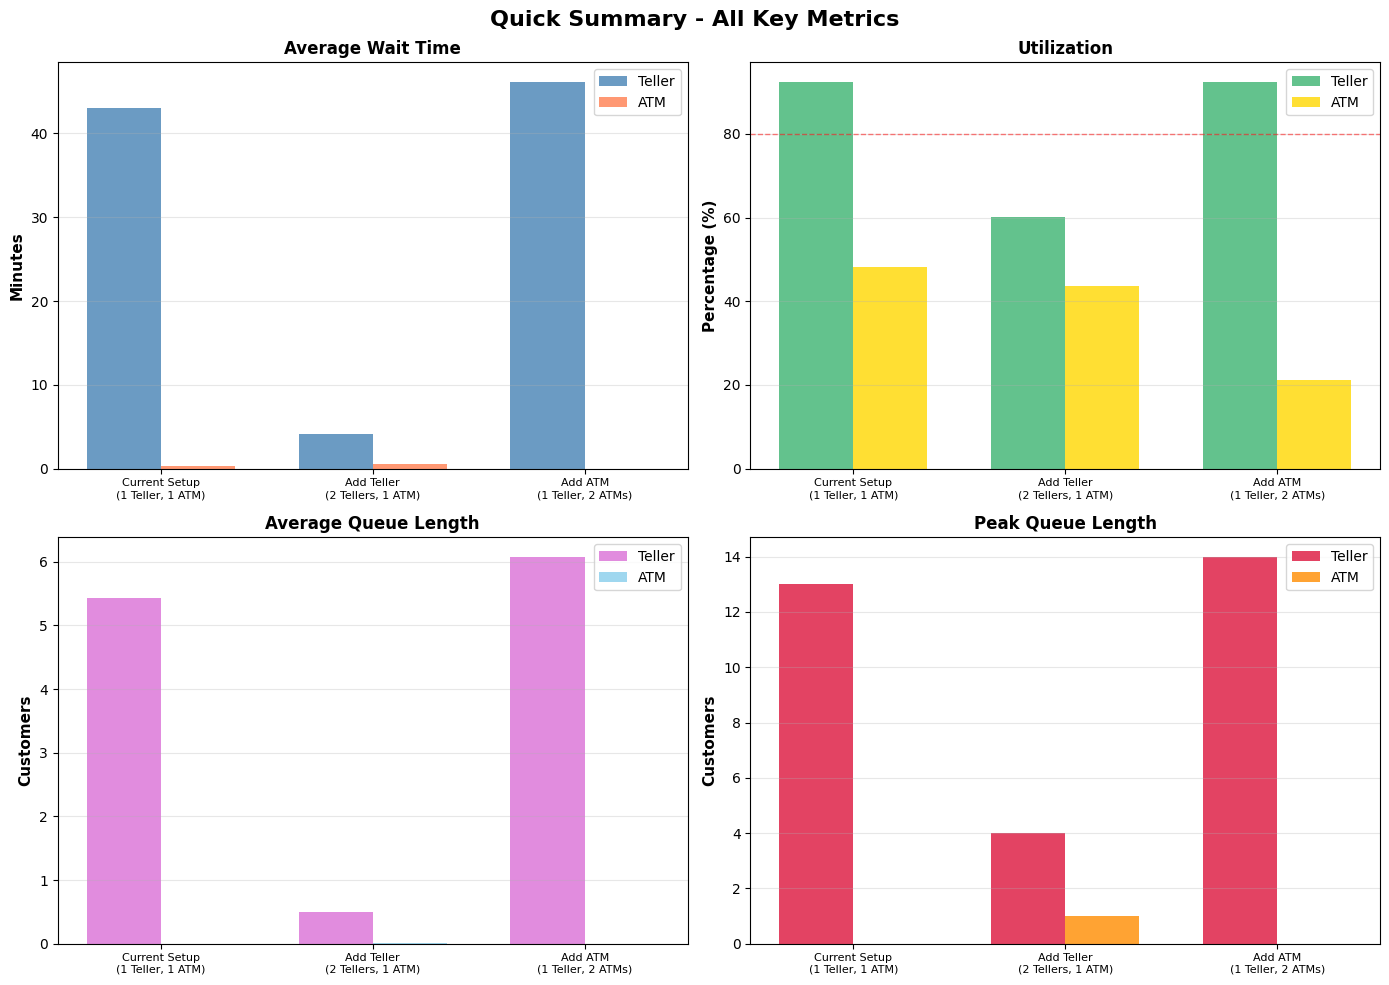


📊 QUICK GUIDE TO READING THE RESULTS

🎯 WHAT TO LOOK FOR:
   1. Wait Time: Lower is better (target: < 5 minutes)
   2. Utilization: 60-80% is ideal (not too busy, not idle)
   3. Queue Length: Lower is better (target: < 3 customers)
   4. Peak Queue: Shows worst-case scenario planning needs

💡 DECISION MAKING:
   • If wait times are high → Add more resources
   • If utilization is low → Reduce resources (save costs)
   • Compare scenarios to find the best balance!


In [11]:
# =============================================================================
# CHART 6: Summary Comparison - All Metrics Side by Side
# =============================================================================
# This gives you a quick overview of ALL the important metrics

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Quick Summary - All Key Metrics', fontsize=16, fontweight='bold')

scenario_names = list(results.keys())
x = np.arange(len(scenario_names))
width = 0.35

# --- Top Left: Wait Times ---
ax1 = axes[0, 0]
teller_waits = [results[s]["teller_wait"] for s in scenario_names]
atm_waits = [results[s]["atm_wait"] for s in scenario_names]
ax1.bar(x - width/2, teller_waits, width, label='Teller', color='steelblue', alpha=0.8)
ax1.bar(x + width/2, atm_waits, width, label='ATM', color='coral', alpha=0.8)
ax1.set_ylabel('Minutes', fontsize=11, fontweight='bold')
ax1.set_title('Average Wait Time', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, fontsize=8)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# --- Top Right: Utilization ---
ax2 = axes[0, 1]
teller_utils = [results[s]["teller_util"]*100 for s in scenario_names]
atm_utils = [results[s]["atm_util"]*100 for s in scenario_names]
ax2.bar(x - width/2, teller_utils, width, label='Teller', color='mediumseagreen', alpha=0.8)
ax2.bar(x + width/2, atm_utils, width, label='ATM', color='gold', alpha=0.8)
ax2.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Utilization', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, fontsize=8)
ax2.axhline(y=80, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# --- Bottom Left: Average Queue Length ---
ax3 = axes[1, 0]
teller_Lq = [results[s]["teller_Lq"] for s in scenario_names]
atm_Lq = [results[s]["atm_Lq"] for s in scenario_names]
ax3.bar(x - width/2, teller_Lq, width, label='Teller', color='orchid', alpha=0.8)
ax3.bar(x + width/2, atm_Lq, width, label='ATM', color='skyblue', alpha=0.8)
ax3.set_ylabel('Customers', fontsize=11, fontweight='bold')
ax3.set_title('Average Queue Length', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(scenario_names, fontsize=8)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# --- Bottom Right: Max Queue Length ---
ax4 = axes[1, 1]
teller_max = [results[s]["teller_max_queue"] for s in scenario_names]
atm_max = [results[s]["atm_max_queue"] for s in scenario_names]
ax4.bar(x - width/2, teller_max, width, label='Teller', color='crimson', alpha=0.8)
ax4.bar(x + width/2, atm_max, width, label='ATM', color='darkorange', alpha=0.8)
ax4.set_ylabel('Customers', fontsize=11, fontweight='bold')
ax4.set_title('Peak Queue Length', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(scenario_names, fontsize=8)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 QUICK GUIDE TO READING THE RESULTS")
print("="*60)
print("\n🎯 WHAT TO LOOK FOR:")
print("   1. Wait Time: Lower is better (target: < 5 minutes)")
print("   2. Utilization: 60-80% is ideal (not too busy, not idle)")
print("   3. Queue Length: Lower is better (target: < 3 customers)")
print("   4. Peak Queue: Shows worst-case scenario planning needs")
print("\n💡 DECISION MAKING:")
print("   • If wait times are high → Add more resources")
print("   • If utilization is low → Reduce resources (save costs)")
print("   • Compare scenarios to find the best balance!")
print("="*60)